1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
import scipy as sp

np.random.seed(1204533)

In [ ]:
N = 500
mu = 0
sigma = 1
arr = sigma * np.random.randn(N) + mu

# Freedman–Diaconis rule to calculate the width and the number of the bins
bin_width = 2*iqr(arr)*(N)**(-1/3)
max_val = np.max(arr)
min_val = np.min(arr)
numb_bins = int((max_val-min_val)/bin_width)

fig, ax = plt.subplots()
hist = ax.hist(arr,bins=numb_bins)
ax.set_title('KDE by hand')
ax.set_ylabel('Data distribution')
fig.tight_layout()

std_ = 1.06*arr.size**(-1/5)
lin = np.linspace(-6+mu,6+mu,200)
fig, ax = plt.subplots()
arr_gauss = np.zeros((len(arr),len(lin)))
for i,elm in enumerate(arr):
    mu = elm
    f = sp.stats.norm(mu,std_)
    arr_gauss[i]=f.pdf(lin)
    ax.plot(lin,f.pdf(lin))
    

area_hist = bin_width * np.sum(hist[0])
print(area_hist)

matrix = np.sum(arr_gauss,axis=0)
area_gauss = sp.integrate.trapz(matrix)
print(area_gauss)
fig, ax = plt.subplots()
ax.plot(lin,matrix)

normalized_matrix = matrix / np.sqrt((np.sum(matrix**2)))
fig, ax = plt.subplots()
ax.plot(lin,normalized_matrix)   

    

sns.distplot(arr)

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

--2018-12-08 15:22:52--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com... 162.125.69.1
Connecting to www.dropbox.com|162.125.69.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2018-12-08 15:22:52--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95de885b68d8c1b7a48401741e.dl.dropboxusercontent.com/cd/0/inline/AXHal6WhPWGhheqoLLMskq5dsbBKnJa9odLkynPQFOhV8nZLrPNiTC31kdVQ21887NpsC6hc-AMpcXMmxUmaKwNE7Z6307768zzCT4i2X8We2G3fp-RPAWD4X8JWSPV-gW4Qo0y8Qy9MvlqRTGicvXHgSmLtDv3GQByQDFT268T_2hqeI38VUgKgw7rLpt1OkXI/file [following]
--2018-12-08 15:22:53--  https://uc95de885b68d8c1b7a48401741e.dl.dropboxusercontent.com/cd/0/inline/AXHal6WhPWGhheqoLLMskq5dsbBKnJa9odLkynPQFOhV8nZLrPNiTC3

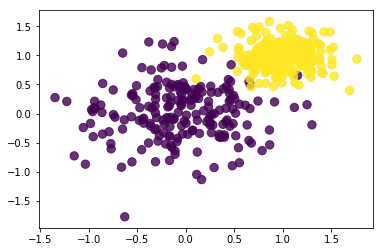

In [5]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')


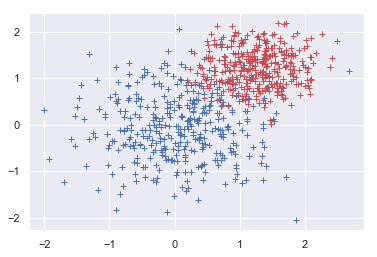

In [9]:
mu = [0, 0]
cov_mat = [[0.5, 0],[0, 0.5]]
x, y  = np.random.multivariate_normal(mu, cov_mat, 360).T
plt.plot(x,y,'b+')
mu = [1.25, 1.25]
cov_mat = [[0.2, 0],[0, 0.2]]
x, y  = np.random.multivariate_normal(mu, cov_mat, 360).T
plt.plot(x,y,'r+')

def scat_plot(number=2, avg = [-10,10], std = [-2, 2]):
    np.random.seed(10)
    for i in range(n):
        avg = np.random.uniform(low=mu[0],high=mu[1],size=2)
        cov = np.random.uniform(std[0],std[1],size=(2,2))
        cov = np.dot(cov, cov.T)
        x, y  = np.random.multivariate_normal(avg, cov, 100).T
        plt.plot(x,y,'*')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [46]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


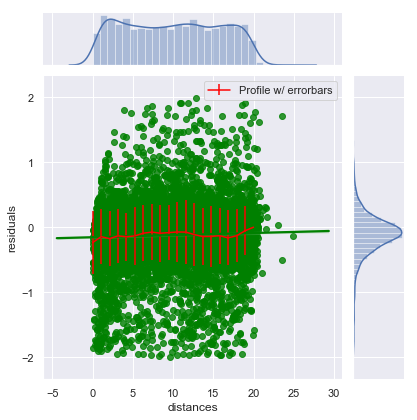

In [61]:
temp = np.load("residuals_261.npy").item()
df = pd.DataFrame(temp)

df = df[abs(df['residuals'])<2]

ln = stats.linregress(df['distances'],df['residuals'])
sns.set(style="darkgrid")
sns.jointplot(df['distances'],df['residuals'],kind='reg,',joint_kws={'color':'green'})

x = np.linspace(0,20,20)
df = df.sort_values('distances')

y = np.zeros(len(x))
count = 0
prev = x[0]
erry = np.zeros(len(x))

for i in x[1:]:
    temp = df[df['distances'] < i]
    temp = temp[temp['distances']>=prev]
    y[count] = temp['residuals'].mean()
    erry[count] = temp['residuals'].std()
    count += 1
    prev = i
    
plt.errorbar(x,y,yerr=erry, color='red', label='Profile w/ errorbars')
plt.legend()
